# Developmental EEG Data 

This notebook analyzes a large dataset of EEG, collected from a developmental sample.

## Dataset Details

This analysis uses the 
[MIPDB dataset](http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/) from the 
[ChildMind Institute](https://childmind.org/).

Note that the pre-processing of the data as available in the dataset, doing data cleaning and calculating power spectra, is done external to this project.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

from bootstrap import bootstrap_corr, bootstrap_diff

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_66425/664193760.py:6: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys
sys.path.append(str(Path('..').resolve()))

from apm.core.db import APMDB
from apm.run import run_measures
from apm.plts import plot_dots
from apm.utils import format_corr
from apm.methods import specparam, irasa, dfa, hurst, hjorth_complexity, lempelziv, app_entropy

## Settings

In [3]:
# Data path
data_path = Path('/Users/tom/Data/VoytekLab/ExtractedSubsets/childmind/')

In [4]:
# Define data information
fs = 500
n_seconds = 30

In [5]:
# Define times vector for data
times = create_times(n_seconds + 1/fs, fs)

In [6]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '32_mipdb_data'

## Load Data

In [7]:
# Load data files
ages = np.load(data_path / 'ages.npy')
data = np.load(data_path / 'data.npy')

In [8]:
# Check the number of subjects
n_subjs = data.shape[0]
assert n_subjs == len(ages)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 111


## Data Checks

In [9]:
ind = 0

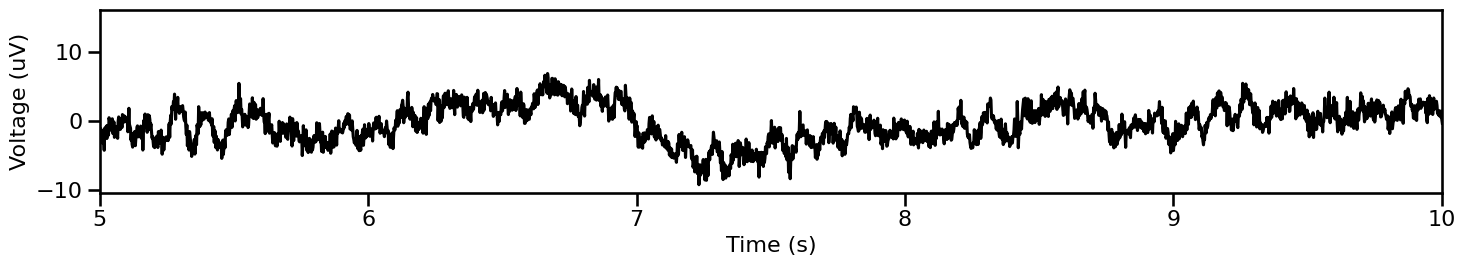

In [10]:
# Plot a segment of time series data
plot_time_series(times, data[ind, :], xlim=[5, 10])

In [11]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[ind, :], fs, nperseg=2*fs, noverlap=fs)

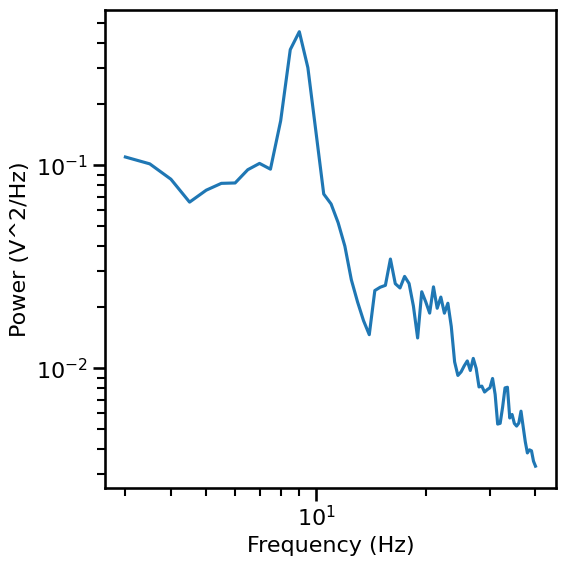

In [12]:
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]))

## Compare Methods

This is a replication of the analysis in the initial EEG dataset. 

In [13]:
# Initialize specparam model
fm = FOOOF(verbose=False)

In [14]:
# General method settings
f_range = [3, 40]

In [15]:
# Define measures to apply
measures = {
    specparam : {'fs' : fs, 'f_range' : f_range},
    irasa : {'fs' : fs, 'f_range' : f_range},
    hurst : {'fs' : fs},
    dfa : {'fs' : fs},
    lempelziv : {},
    hjorth_complexity : {},
    app_entropy : {}
}

In [16]:
# Compute measures of interest on the data
outputs = run_measures(data, measures)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf

## Compare Measures

#### Compare Exponent Measures

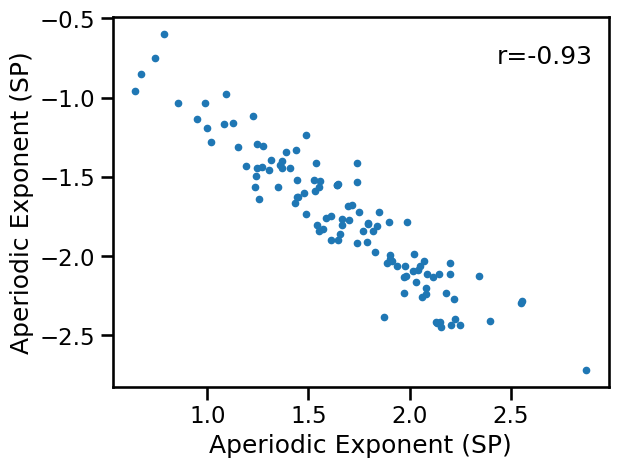

In [17]:
plot_dots(outputs['specparam'], outputs['irasa'],
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (SP)',
          save_fig=SAVE_FIG, file_name='mipdb_exp_exp_comp' + EXT, file_path=FIGPATH)

In [18]:
# Statistically compare specparam and irasa exponent estimates
sp_ir_corrs = bootstrap_corr(outputs['specparam'], outputs['irasa'])
print('  SP-EXP & IR-EXP:  ', format_corr(*sp_ir_corrs))

  SP-EXP & IR-EXP:   r=-0.932  CI[-0.953, -0.894],  p=0.000


#### Compare exponent to LZ Complexity

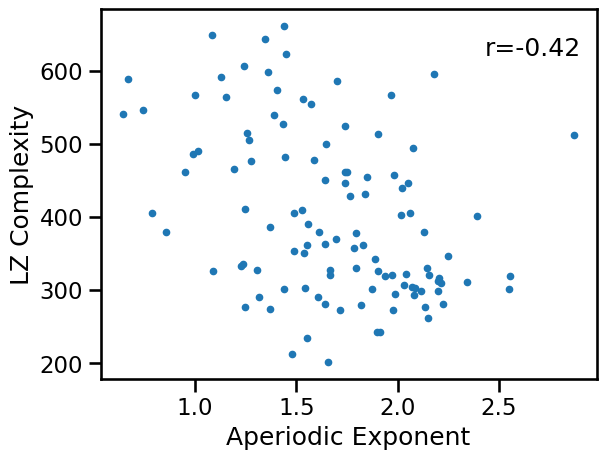

In [19]:
plot_dots(outputs['specparam'], outputs['lempelziv'],
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity',
          save_fig=SAVE_FIG, file_name='mipdb_exp_lz_comp' + EXT, file_path=FIGPATH)

In [20]:
# Statistically compare exponent and Lempel-Ziv estimates
spexp_lzc_corrs = bootstrap_corr(outputs['specparam'], outputs['lempelziv'])
irexp_lzc_corrs = bootstrap_corr(outputs['irasa'], outputs['lempelziv'])
print('  SP-EXP & LZC:  ', format_corr(*spexp_lzc_corrs))
print('  IR-EXP & LZC:  ', format_corr(*irexp_lzc_corrs))

  SP-EXP & LZC:   r=-0.422  CI[-0.564, -0.262],  p=0.000
  IR-EXP & LZC:   r=+0.409  CI[+0.244, +0.557],  p=0.000


#### Compare exponent to Entropy

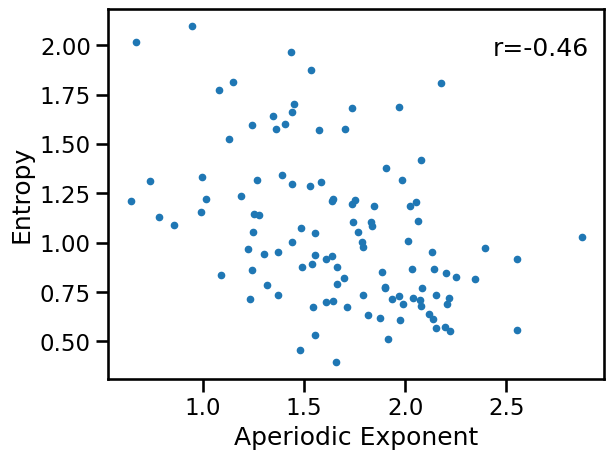

In [21]:
plot_dots(outputs['specparam'], outputs['app_entropy'],
          xlabel='Aperiodic Exponent', ylabel='Entropy',
          save_fig=SAVE_FIG, file_name='mipdb_exp_ent_comp' + EXT, file_path=FIGPATH)

In [22]:
# Statistically compare exponent and entropy estimates
spexp_ent_corrs = bootstrap_corr(outputs['specparam'], outputs['app_entropy'])
irexp_ent_corrs = bootstrap_corr(outputs['irasa'], outputs['app_entropy'])
print('  SP-EXP & ENT:  ', format_corr(*spexp_ent_corrs))
print('  IR-EXP & ENT:  ', format_corr(*irexp_ent_corrs))

  SP-EXP & ENT:   r=-0.463  CI[-0.592, -0.306],  p=0.000
  IR-EXP & ENT:   r=+0.467  CI[+0.312, +0.593],  p=0.000


## Check Age Relationship

#### Compare age to exponent

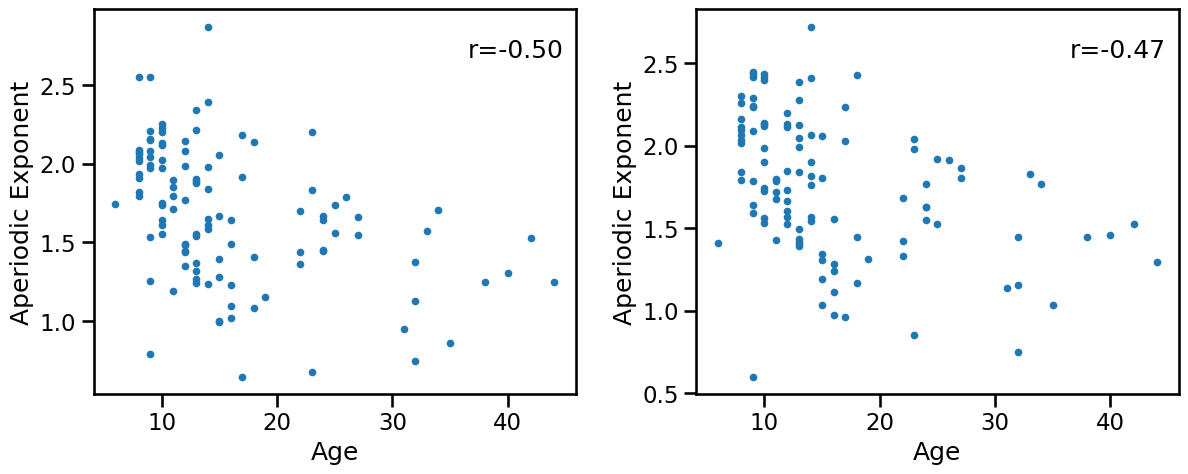

In [23]:
_, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_dots(ages, outputs['specparam'], ax=axes[0],
          xlabel='Age', ylabel='Aperiodic Exponent (SP)')
plot_dots(ages, -1 * outputs['irasa'], ax=axes[1],
          xlabel='Age', ylabel='Aperiodic Exponent (IR)')
plt.subplots_adjust(wspace=0.25)
if SAVE_FIG: plt.savefig(FIGPATH / ('mipdb_age_exp' + EXT))

In [36]:
# Statistically compare exponent and age
spexp_age_corrs = bootstrap_corr(ages, outputs['specparam'])
irexp_age_corrs = bootstrap_corr(ages, outputs['irasa'])
exp_corr_diff = bootstrap_diff(ages, outputs['specparam'], -1 * outputs['irasa'])
print('  SP-EXP & age:    \t\t', format_corr(*spexp_age_corrs))
print('  IR-EXP & age:    \t\t', format_corr(*irexp_age_corrs))
print('  SP/IR-EXP & age diff:  \t', format_corr(*exp_corr_diff))

  SP-EXP & age:    		 r=-0.502  CI[-0.623, -0.357],  p=0.000
  IR-EXP & age:    		 r=+0.469  CI[+0.319, +0.597],  p=0.000
  SP/IR-EXP & age diff:  	 r=-0.034  CI[-0.119, +0.045],  p=0.418


#### Compare age to LZ Complexity

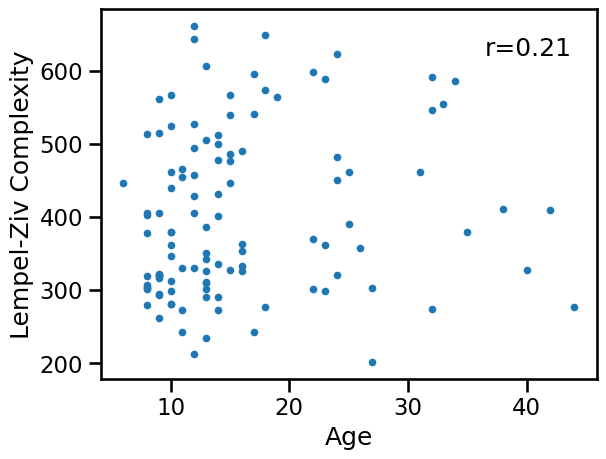

In [25]:
plot_dots(ages, outputs['lempelziv'], 
          xlabel='Age', ylabel='Lempel-Ziv Complexity',
          save_fig=SAVE_FIG, file_name='mipdb_age_lz' + EXT, file_path=FIGPATH)

In [41]:
# Statistically compare Lempel-Ziv complexity and age
lcz_age_corrs = bootstrap_corr(ages, outputs['lempelziv'])
exp_lcz_corr_diff = bootstrap_diff(ages, -1 * outputs['specparam'], outputs['lempelziv'])
print('  LCZ & age:  \t\t', format_corr(*lcz_age_corrs))
print('  EXP/LCZ & age diff:  \t', format_corr(*exp_lcz_corr_diff))

  LCZ & age:  		 r=+0.213  CI[+0.025, +0.392],  p=0.025
  EXP/LCZ & age diff:  	 r=+0.289  CI[+0.105, +0.472],  p=0.001


#### Compare age to Hjorth Complexity

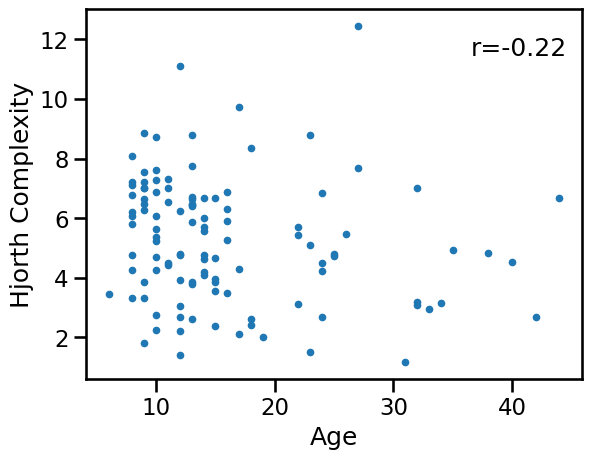

In [27]:
plot_dots(ages, outputs['hjorth_complexity'], 
          xlabel='Age', ylabel='Hjorth Complexity',
          save_fig=SAVE_FIG, file_name='mipdb_age_hjc' + EXT, file_path=FIGPATH)

In [42]:
# Statistically compare Hjorth complexity and age
hjc_age_corrs = bootstrap_corr(ages, outputs['hjorth_complexity'])
exp_hjc_corr_diff = bootstrap_diff(ages, -1 * outputs['specparam'], outputs['lempelziv'])
print('  HJC & age:  \t\t', format_corr(*hjc_age_corrs))
print('  EXP/HJC & age diff:  \t', format_corr(*exp_hjc_corr_diff))

  HJC & age:  		 r=-0.218  CI[-0.393, -0.033],  p=0.021
  HJC/LCZ & age diff:  	 r=+0.289  CI[+0.105, +0.475],  p=0.001


#### Compare age to Entropy

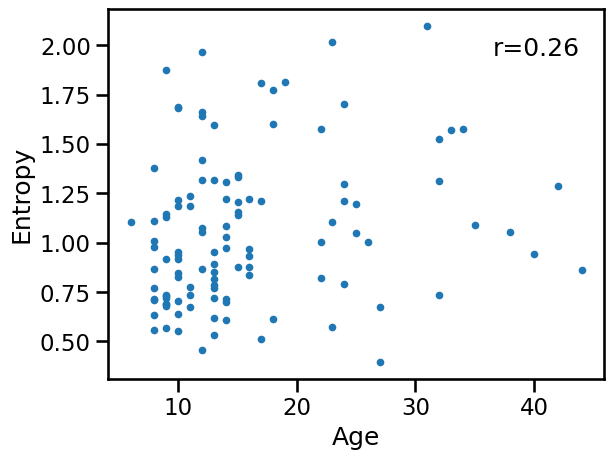

In [29]:
plot_dots(ages, outputs['app_entropy'], xlabel='Age', ylabel='Entropy', 
          save_fig=SAVE_FIG, file_name='mipdb_age_ent' + EXT, file_path=FIGPATH)

In [44]:
# Statistically compare approximate entropy and age
ent_age_corrs = bootstrap_corr(ages, outputs['app_entropy'])
exp_ent_corr_diff = bootstrap_diff(ages, -1 * outputs['specparam'], outputs['app_entropy'])
print('  ENT & age:  \t\t', format_corr(*ent_age_corrs))
print('  EXP/ENT & age diff:  \t', format_corr(*exp_ent_corr_diff))

  ENT & age:  		 r=+0.260  CI[+0.085, +0.428],  p=0.006
  EXP/ENT & age diff:  	 r=+0.242  CI[+0.066, +0.418],  p=0.007


## Conclusions

Interim conclusions from this analysis:
- specparam & IRASA estimates are consistent in this dataset
- aperiodic exponent is moderately correlated with time domain measures

Notably, these findings are a replication of the same analyses on the previous EEG dataset.

In addition, in this larger dataset, we could analyze the relationship between our measures of interest, and age, finding that:
- specparam & IRASA estimates of exponent are equivalently correlated with age
- time domain measures are more moderately correlated with age than exponent measures